# SEMANTIC SEGMENTATION OF CARCASSES USING DEEP LEARNING

**Asger Bjørn Larsen (s204306), Mads Heideby Nygaard (s204294), Marcus Leander Jensen (s200705)**

This Notebook shows some of the contents of Main_Training.py and Local_test.py. Its primary purpose is to show the code, but the python scripts themselves have been used to get results.

## Import

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date
from skimage import io, color
from skimage.color import label2rgb
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import gc

import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Custom modules (ensure paths are correct)
from Functions.Carcass_dataloader2 import *
from Functions.Carcass_trainer import *
from Functions.CustomNets import *
from Functions.Scoring_Metrics import *
from Functions.VisualizeMasks import *

# Utility Function

In [9]:
# Function used for splitting a dataset into two fractions. Due to the heaviness of the task no validation is done while training. This function is the usedd to split the data into training data and test data. 
def train_val_dataset(dataset, val_split=0.25, random_state=42):
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))), test_size=val_split, random_state=random_state
    )
    datasets = {
        "train": Subset(dataset, train_idx),
        "val": Subset(dataset, val_idx),
    }
    return datasets

## Show data

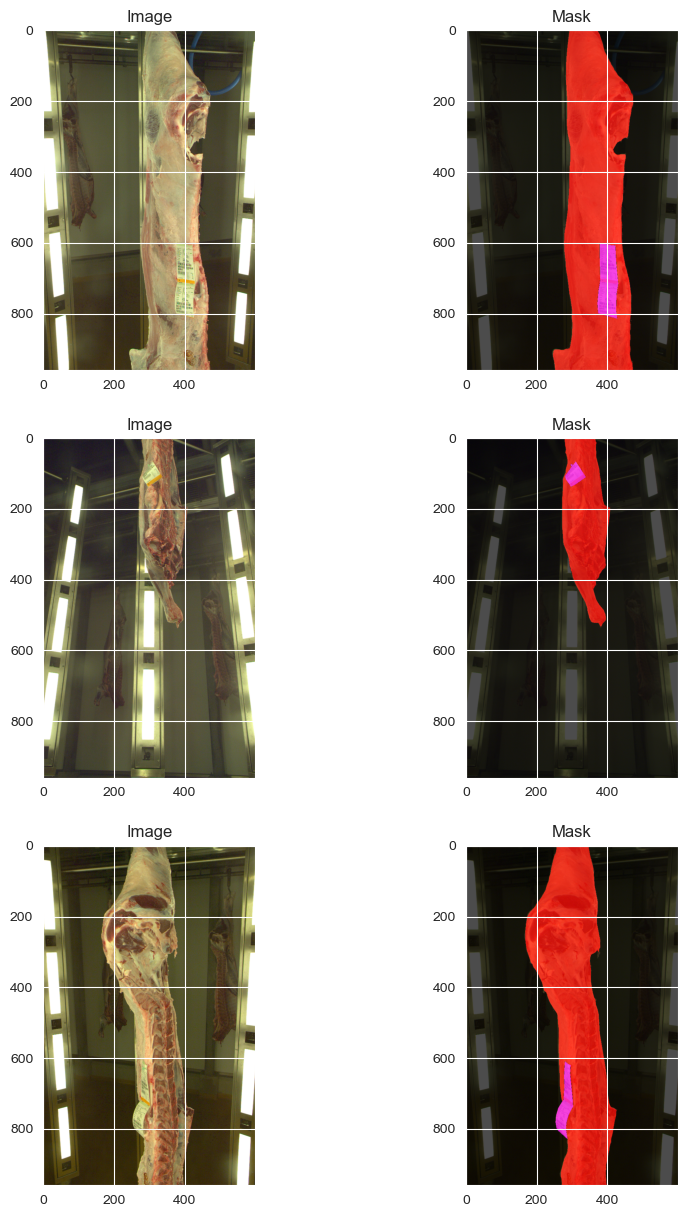

In [13]:
def get_image(path):
    image=io.imread(path)
    return image
    
def get_mask(path):
    mask=io.imread(path,as_gray=True)
    return mask
    
def load_data(images_paths, labels_paths):
    """Load images and labels from two paths as a generator of tuples"""    

    if not len(labels_paths)==len(labels_paths):
        raise ValueError('Image folder and label folders do not match')

    return ((get_image(im_path), get_mask(m_path)) for im_path, m_path in zip(images_paths, labels_paths))

## Test function 

data_dir = os.path.join("Data")
image_dir = os.path.join(data_dir, "images_correct_labels")
mask_dir = os.path.join(data_dir, "mask_images_correct_labels")

X_paths=[image_dir+'/'+image_name for image_name in os.listdir(image_dir)]
y_paths=[mask_dir+'/'+mask_name for mask_name in os.listdir(mask_dir)]

loader=load_data(X_paths,y_paths)

n_samples = 3

f, ax = plt.subplots(n_samples,2,figsize=(10,15))

for i in range(n_samples):
    img, label = next(loader)
    ax[i,0].imshow(img)
    ax[i,0].set_title('Image')
    ax[i,1].imshow(draw_masks(img,label))
    ax[i,1].set_title('Mask')

## Argument Parsing Setup
Since Jupyter Notebooks don't use CLI arguments directly, the parameters can be set interactively in the cell below:

In [17]:
# Parameters (replace argparse with direct assignment)
image_dir_name = "images_correct_labels"
label_dir_name = "mask_images_correct_labels"
model_pick = "dlv3"  # Options: 'fcn', 'unet', 'unet_pretrained', 'dlv3', 'dlv3p'
loss = "FL"  # Options: 'FL', 'TL', 'CE'
n_epochs = 2

## Training setup

100%|██████████| 2/2 [02:47<00:00, 83.87s/it]


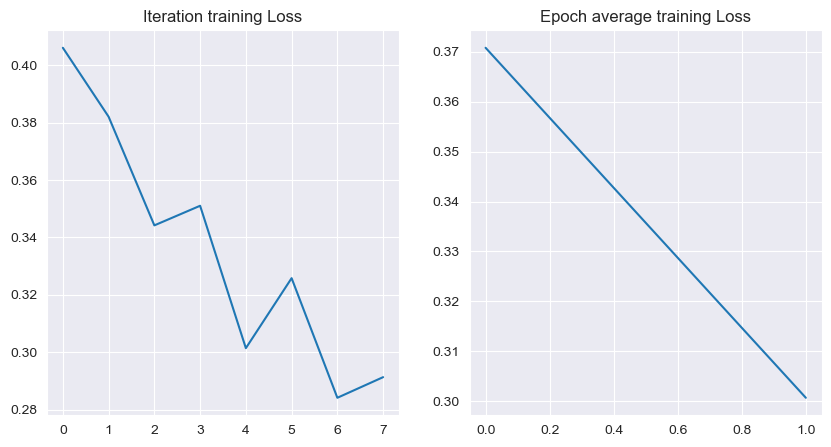

In [22]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

data_dir = "Data"
output_dir = os.path.join(data_dir, f"output_{loss.lower()}")
image_dir = os.path.join(data_dir, image_dir_name)
label_dir = os.path.join(data_dir, label_dir_name)

model_list=["fcn",
            "unet",
            "unet_pretrained",
            "dlv3",
            "dlv3p"]
    
loss_list=["FL",
           "TL",
           "CE"]

# Number of classes in images
num_classes = 6
# Model setup
if model_pick.lower() == 'fcn':
    model_name="FCN_custom_sorted_classes"
    model=FCN(num_classes)

elif model_pick.lower() == 'unet':
    # Setup model
    model_name="UNet_custom_sorted_classes"
    model = UNet(num_classes)

elif model_pick.lower() == 'unet_pretrained':
    # Setup model
    model_name="UNet_resnet50_pretrained_sorted_classes"
    model = smp.Unet('resnet50',in_channels=3, encoder_weights='imagenet',classes=num_classes, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

elif model_pick.lower() == 'dlv3':
    # Setup model
    model_name="deeplab_v3_resnet50_pretrained_sorted_classes"
    model = smp.DeepLabV3('resnet50',in_channels=3, encoder_weights='imagenet',classes=num_classes)

elif model_pick.lower() == 'dlv3p':
    # Setup model
    model_name="DeepLabV3Plus_resnet50_pretrained_sorted_classes"
    model = smp.DeepLabV3Plus('resnet50',in_channels=3, encoder_weights='imagenet',classes=num_classes)

else:
    raise ValueError(f"{model_pick} in not not in {model_list}")

# pick loss
if loss.lower() == "fl":
    criterion = smp.losses.FocalLoss(mode="multiclass", alpha=0.7, gamma=2)
    class_weights = None
elif loss.lower() == "tl":
    criterion = smp.losses.TverskyLoss(mode="multiclass", alpha=0.4, smooth=0.6)
    class_weights = None
elif loss.lower() == "ce":
    criterion = nn.CrossEntropyLoss
    class_weights = torch.tensor([1.0,1.0,3.0,2.0,2.0,3.0])    
else:
    raise ValueError(f"{loss} in not not in {loss_list}")     

optimizer = optim.Adam
dataset = CarcassDataset(image_dir, label_dir,transform=True)
split_datasets = train_val_dataset(dataset,val_split=0.20)
data_loader = DataLoader
lr=0.0001
batch_size=2


args = (model,
        criterion,
        optimizer,
        split_datasets['train'],
        data_loader,
        device,
        lr,
        n_epochs,
        batch_size,
        class_weights)

trainer = Trainer(*args)

# start training
step_losses, epoch_losses = trainer.train(n_epochs,plot=False)

# Plotting training losses
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[0].set_title("Iteration training Loss")
axes[1].plot(epoch_losses)
axes[1].set_title("Epoch average training Loss")
plt.show()

# Testing

In [24]:
# Test with dice function on all test data
split_datasets["val"].dataset.transform=False

data_loader_test = DataLoader(split_datasets["val"], batch_size=batch_size)

all_scores=dice_validation(model, data_loader_test, device, num_classes)  # run test from Scoring Metrics
mean_scores=np.nanmean(all_scores,axis=0)

print(f"{model_name} dice results")
for c in range(num_classes):
    print(f"Class_{c}:\t{mean_scores[c]}")

# Usually the raw data would be save to a file. Now we print to preview the results 
#np.save(output_dir+f"/{model_name}_Raw_dice_{date.today()}",all_scores)  # save all scores to np.array-file

#with open(output_dir+f"/{model_name}_dice_results_{date.today()}.txt","w") as f:  # Save mean scores per class to a .txt
 #   for c in range(num_classes):
 #       f.write(f"Class_{c}:\t{mean_scores[c]}\n")

deeplab_v3_resnet50_pretrained_sorted_classes dice results
Class_0:	0.9705921176141292
Class_1:	0.9190934494700534
Class_2:	0.0
Class_3:	0.0
Class_4:	0.038381742738589186
Class_5:	0.0


## Model prediction visualisation

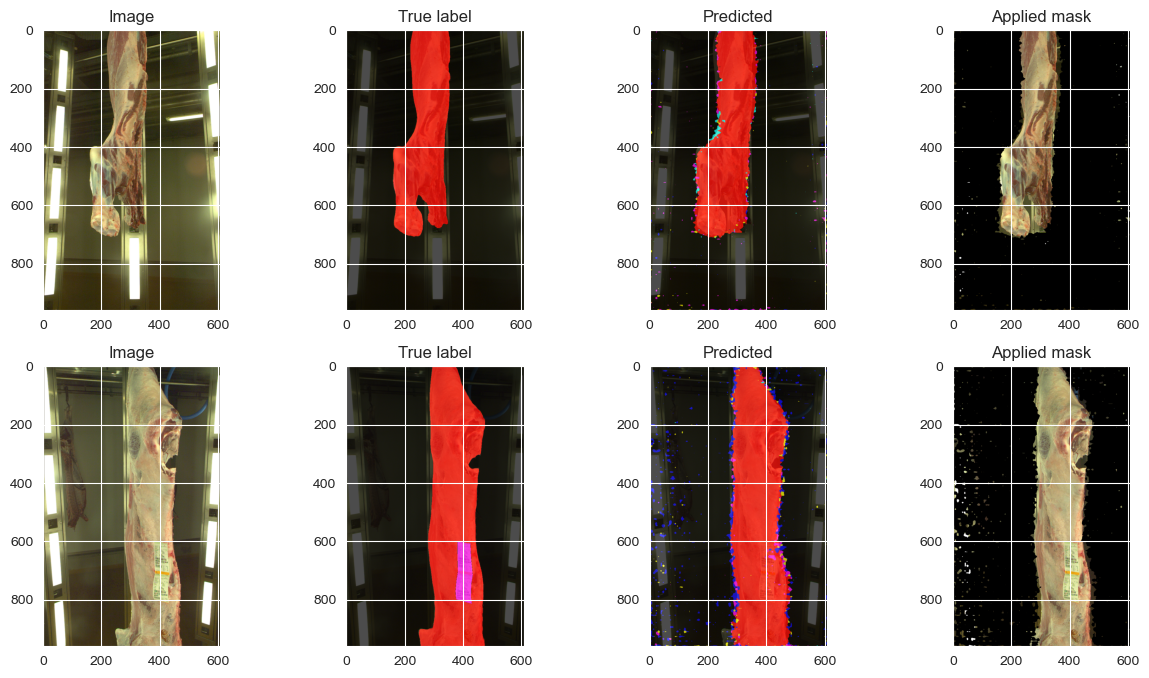

In [28]:
data_iter= iter(data_loader_test)
X, Y = next(data_iter)

# make prediction with model trained above
with torch.no_grad():
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)


fig, axes = plt.subplots(batch_size, 4, figsize=(3*5, batch_size*4)) # setup plot

for i in range(batch_size):
    image = X[i].permute(1, 2, 0).cpu().detach().numpy().astype(int)  # make the image from a tensor to skimage-type np array
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    applied_mask_img=image.copy()
    applied_mask_img[label_class_predicted==0]=0
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(draw_masks(image,label_class))
    axes[i, 1].set_title("True label")
    axes[i, 2].imshow(draw_masks(image,label_class_predicted))
    axes[i, 2].set_title("Predicted")
    axes[i, 3].imshow(applied_mask_img)
    axes[i, 3].set_title("Applied mask")

### From our trained models

In [31]:
# Load model
model_path=os.path.join(data_dir,"output_fl","deeplab_v3_resnet50_pretrained_sorted_classes_2024-12-12.pth")
model_name="deeplab_v3_resnet50_pretrained_sorted_classes"
model = smp.DeepLabV3('resnet50',in_channels=3, encoder_weights='imagenet',classes=num_classes)
model.load_state_dict(torch.load(model_path,weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

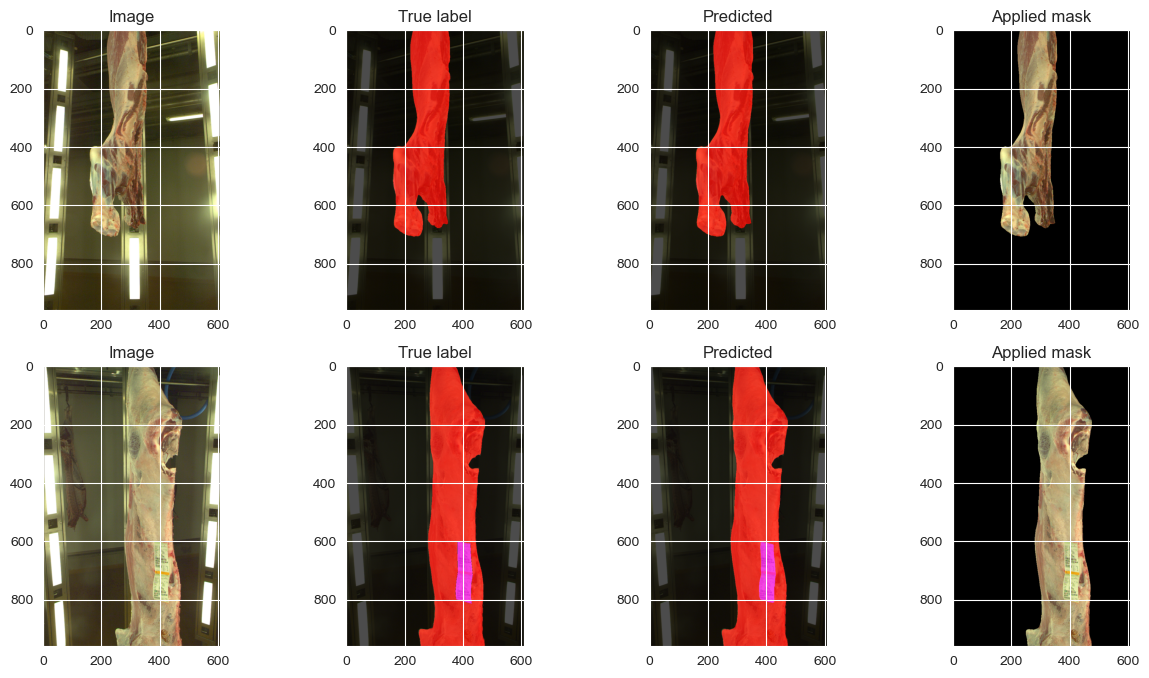

In [32]:
data_iter= iter(data_loader_test)
X, Y = next(data_iter)

# make prediction with model trained above
with torch.no_grad():
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)


fig, axes = plt.subplots(batch_size, 4, figsize=(3*5, batch_size*4)) # setup plot

for i in range(batch_size):
    image = X[i].permute(1, 2, 0).cpu().detach().numpy().astype(int)  # make the image from a tensor to skimage-type np array
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    applied_mask_img=image.copy()
    applied_mask_img[label_class_predicted==0]=0
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(draw_masks(image,label_class))
    axes[i, 1].set_title("True label")
    axes[i, 2].imshow(draw_masks(image,label_class_predicted))
    axes[i, 2].set_title("Predicted")
    axes[i, 3].imshow(applied_mask_img)
    axes[i, 3].set_title("Applied mask")

# Visualisations
Due to our data being confidential we will not show a lot of segmentations.

# Plotting

{'FCN - untrained': 0.4985747529307478, 'Deeplab V3 - pretrained': 0.7335000874795957, 'Deeplab V3 plus - pretrained': 0.7843453966887884, 'UNet - untrained': 0.4446308755018125, 'UNet - pretrained': 0.6801582350266989}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


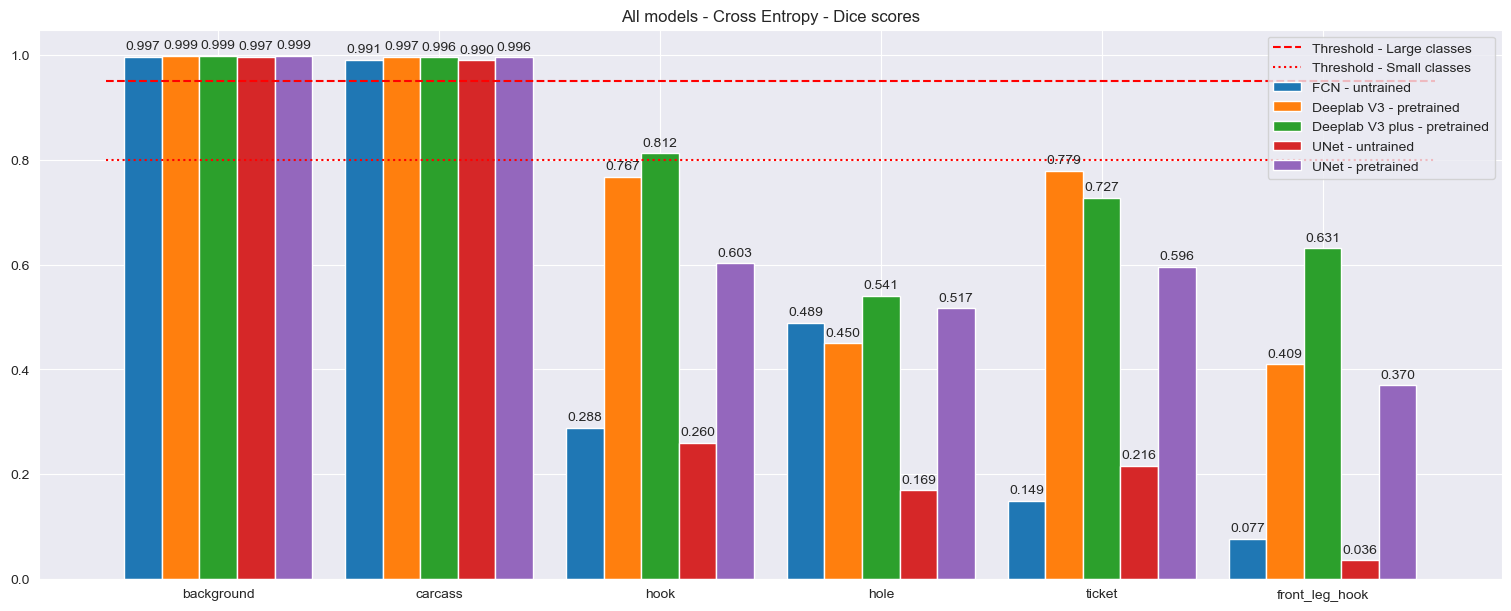

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

classes_labels = {"Class_0":"background","Class_1":"carcass", "Class_2":"hook", "Class_3":"hole", "Class_4":"ticket", "Class_5":"front_leg_hook"}
data_dir=os.path.join("Data")
in_dir = os.path.join(data_dir,"Plotting - cross en")
paths = [os.path.join(in_dir,name) for name in sorted(os.listdir(in_dir))]

runs=["FCN - untrained",
      "Deeplab V3 - pretrained",
      "Deeplab V3 plus - pretrained",
      "UNet - untrained",
      "UNet - pretrained",
      ]

dice_raw_scores=[np.load(path) for path in paths]

dice_mean=[np.nanmean(mat, axis=0) for mat in dice_raw_scores]
dice_mean=np.vstack(dice_mean)
dice_CE=dice_mean

avescores_CE={run:num for run,num in zip(runs, dice_mean.mean(axis=1))}
print(avescores_CE)

dice_std=[np.nanstd(mat, axis=0) for mat in dice_raw_scores]
dice_std=np.concatenate(dice_std)

classes = [f"Class_{i}" for i in range(len(dice_raw_scores[0][0,:]))]

x = np.arange(len(classes))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0



fig, ax = plt.subplots(figsize=(15,6),layout='constrained')

for idx in range(dice_mean.shape[0]):
    offset = width * multiplier
    rects = ax.bar(x + offset, dice_mean[idx,:], width, label=runs[idx])
    ax.bar_label(rects, fmt="{:.3f}", padding=3)
    multiplier += 1

ax.set_xticks(x+width*len(runs)/(len(runs)/2) if len(runs)%2!=0 else x+width*len(runs)/2)
ax.set_xticklabels([classes_labels[c] for c in classes])

plt.hlines(0.95,-width,x[-1]+width*len(runs), linestyles='dashed',label="Threshold - Large classes", color="red")
plt.hlines(0.80,-width,x[-1]+width*len(runs), linestyles='dotted',label="Threshold - Small classes", color="red")

plt.title("All models - Cross Entropy - Dice scores")
plt.legend()
# plt.savefig("All models - Cross Entropy - Dice scores.eps")
# plt.show()

['1_FCN_custom_sorted_classes_fl_Raw_dice_2024-12-16.npy', '2_Deeplab_v3_resnet50_pretrained_sorted_classes_fl_Raw_dice_2024-12-16.npy', '3_DeepLabV3Plus_resnet50_pretrained_sorted_classes_fl_Raw_dice_2024-12-16.npy', '4_UNet_custom_sorted_classes_fl_Raw_dice_2024-12-16.npy', '5_UNet_resnet50_pretrained_sorted_classes_fl_Raw_dice_2024-12-16.npy']
{'FCN - untrained': 0.47611925355353457, 'Deeplab V3 - pretrained': 0.728126065202633, 'Deeplab V3 plus - pretrained': 0.7836006865017268, 'UNet - untrained': 0.5400675083941098, 'UNet - pretrained': 0.7507629977662079}


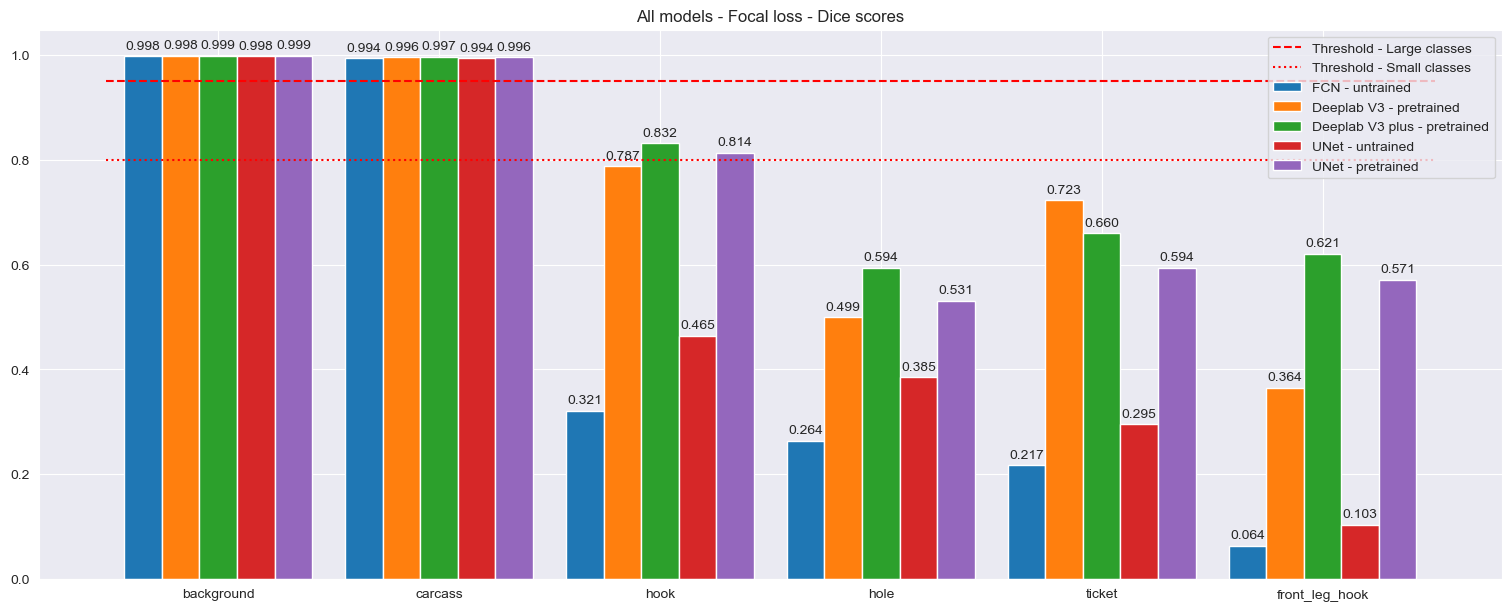

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

classes_labels = {"Class_0":"background","Class_1":"carcass", "Class_2":"hook", "Class_3":"hole", "Class_4":"ticket", "Class_5":"front_leg_hook"}
in_dir = os.path.join(data_dir,"Plotting - Focal")

print(list(sorted(os.listdir(in_dir))))

paths = [os.path.join(in_dir,name) for name in sorted(os.listdir(in_dir))]

runs=["FCN - untrained",
      "Deeplab V3 - pretrained",
      "Deeplab V3 plus - pretrained",
      "UNet - untrained",
      "UNet - pretrained",
      ]

dice_raw_scores=[np.load(path) for path in paths]

dice_mean=[np.nanmean(mat, axis=0) for mat in dice_raw_scores]
dice_mean=np.vstack(dice_mean)
dice_FL=dice_mean

avescores_FL={run:num for run,num in zip(runs, dice_mean.mean(axis=1))}
print(avescores_FL)

dice_std=[np.nanstd(mat, axis=0) for mat in dice_raw_scores]
dice_std=np.concatenate(dice_std)

classes = [f"Class_{i}" for i in range(len(dice_raw_scores[0][0,:]))]

x = np.arange(len(classes))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0



fig, ax = plt.subplots(figsize=(15,6),layout='constrained')

for idx in range(dice_mean.shape[0]):
    offset = width * multiplier
    rects = ax.bar(x + offset, dice_mean[idx,:], width, label=runs[idx])
    ax.bar_label(rects, fmt="{:.3f}", padding=3)
    multiplier += 1

ax.set_xticks(x+width*len(runs)/(len(runs)/2) if len(runs)%2!=0 else x+width*len(runs)/2)
ax.set_xticklabels([classes_labels[c] for c in classes])

plt.hlines(0.95,-width,x[-1]+width*len(runs), linestyles='dashed',label="Threshold - Large classes", color="red")
plt.hlines(0.80,-width,x[-1]+width*len(runs), linestyles='dotted',label="Threshold - Small classes", color="red")

plt.title("All models - Focal loss - Dice scores")
plt.legend()
# plt.savefig("All models - Focal loss - Dice scores.eps")
# plt.show()

['1_FCN_custom_sorted_classes_tl_Raw_dice_2024-12-16.npy', '2_Deeplab_v3_resnet50_pretrained_sorted_classes_tl_Raw_dice_2024-12-16.npy', '3_DeepLabV3Plus_resnet50_pretrained_sorted_classes_tl_Raw_dice_2024-12-16.npy', '4_UNet_custom_sorted_classes_tl_Raw_dice_2024-12-16.npy', '5_UNet_resnet50_pretrained_sorted_classes_tl_Raw_dice_2024-12-16.npy']
{'FCN - untrained': 0.40183689578656007, 'Deeplab V3 - pretrained': 0.5777896095887427, 'Deeplab V3 plus - pretrained': 0.6520454058496857, 'UNet - untrained': 0.3531353176185675, 'UNet - pretrained': 0.5601199231027579}


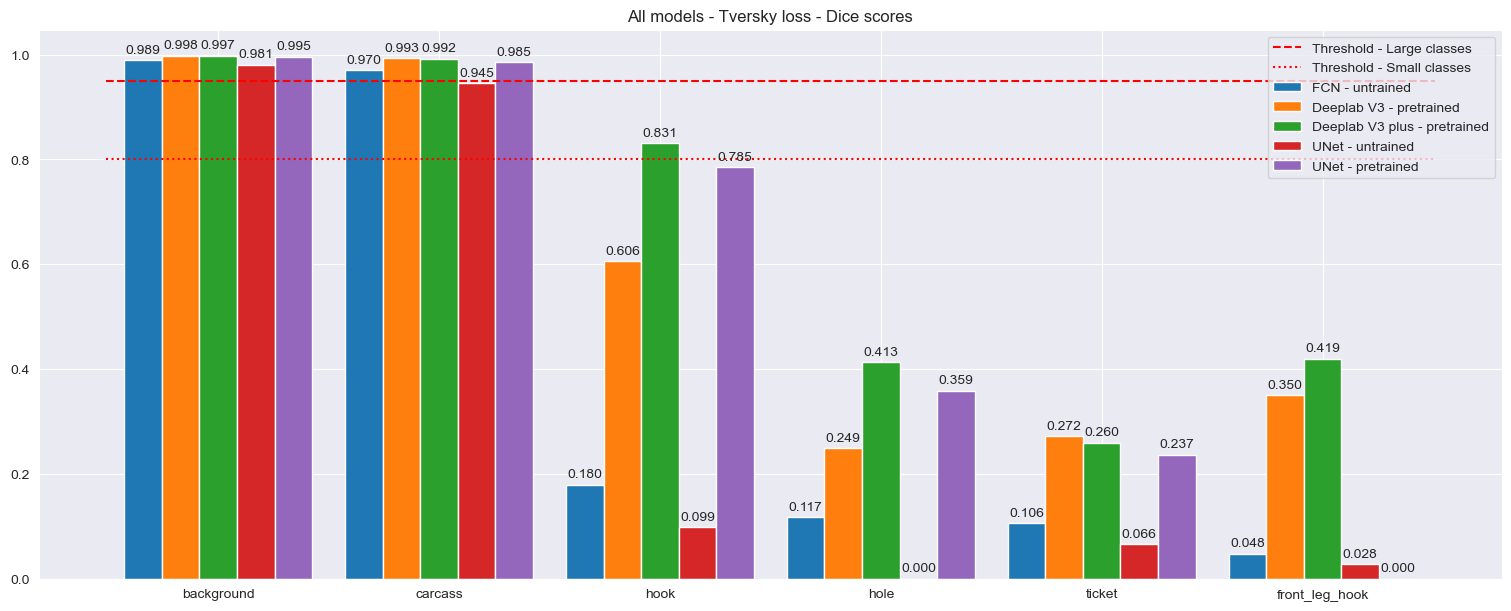

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

classes_labels = {"Class_0":"background","Class_1":"carcass", "Class_2":"hook", "Class_3":"hole", "Class_4":"ticket", "Class_5":"front_leg_hook"}
in_dir = os.path.join(data_dir,"Plotting - tversky")

print(list(sorted(os.listdir(in_dir))))

paths = [os.path.join(in_dir,name) for name in sorted(os.listdir(in_dir))]

runs=["FCN - untrained",
      "Deeplab V3 - pretrained",
      "Deeplab V3 plus - pretrained",
      "UNet - untrained",
      "UNet - pretrained",
      ]

dice_raw_scores=[np.load(path) for path in paths]

dice_mean=[np.nanmean(mat, axis=0) for mat in dice_raw_scores]
dice_mean=np.vstack(dice_mean)
dice_TL=dice_mean

avescores_TL={run:num for run,num in zip(runs, dice_mean.mean(axis=1))}
print(avescores_TL)

dice_std=[np.nanstd(mat, axis=0) for mat in dice_raw_scores]
dice_std=np.concatenate(dice_std)

classes = [f"Class_{i}" for i in range(len(dice_raw_scores[0][0,:]))]

x = np.arange(len(classes))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0



fig, ax = plt.subplots(figsize=(15,6),layout='constrained')

for idx in range(dice_mean.shape[0]):
    offset = width * multiplier
    rects = ax.bar(x + offset, dice_mean[idx,:], width, label=runs[idx])
    ax.bar_label(rects, fmt="{:.3f}", padding=3)
    multiplier += 1

ax.set_xticks(x+width*len(runs)/(len(runs)/2) if len(runs)%2!=0 else x+width*len(runs)/2)
ax.set_xticklabels([classes_labels[c] for c in classes])

plt.hlines(0.95,-width,x[-1]+width*len(runs), linestyles='dashed',label="Threshold - Large classes", color="red")
plt.hlines(0.80,-width,x[-1]+width*len(runs), linestyles='dotted',label="Threshold - Small classes", color="red")

plt.title("All models - Tversky loss - Dice scores")
plt.legend()
# plt.savefig("All models - Tversky loss - Dice scores.eps")
# plt.show()

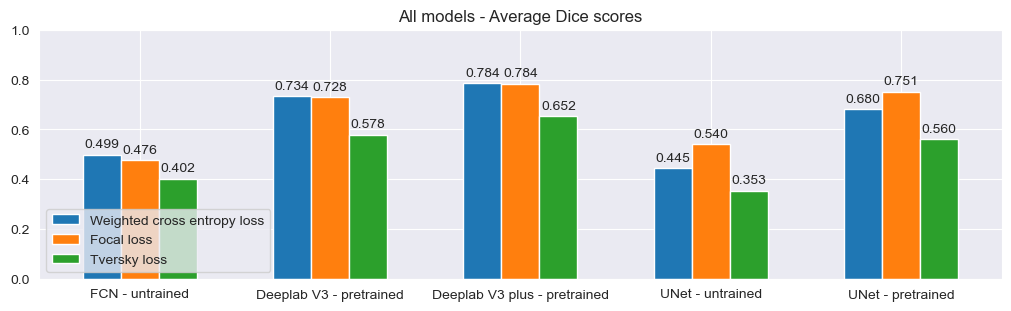

In [4]:
avescores=[avescores_CE, avescores_FL, avescores_TL]
loss_name=["Weighted cross entropy loss","Focal loss","Tversky loss"]

runs=["FCN - untrained",
      "Deeplab V3 - pretrained",
      "Deeplab V3 plus - pretrained",
      "UNet - untrained",
      "UNet - pretrained",
      ]

x = np.arange(len(runs))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,3),layout='constrained')

for idx in range(len(avescores)):
    offset = width * multiplier
    rects = ax.bar(x + offset, [avescores[idx][name] for name in runs], width, label=loss_name[idx])
    ax.bar_label(rects, fmt="{:.3f}", padding=3)
    multiplier += 1

ax.set_xticks(x+width*len(runs)/5)
ax.set_xticklabels(runs)
ax.set_ylim(0,1)

plt.title("All models - Average Dice scores")
plt.legend(loc=3)
plt.savefig("All models - Average Dice scores.png")
plt.show()

#with open("All models - Average Dice scores.txt","w") as f:
#    f.write(f"Model\tWCE\tFL\tTL\n")
#    for i in range(len(runs)):
#        f.write(f"{runs[i]}\t"+"\t".join([f"{avescores[l][runs[i]]:.3}" for l in range(len(avescores))])+"\n")

In [5]:
carcassscores=[dice_CE[:,1], dice_FL[:,1], dice_TL[:,1]]
carcassscores=np.vstack(carcassscores)

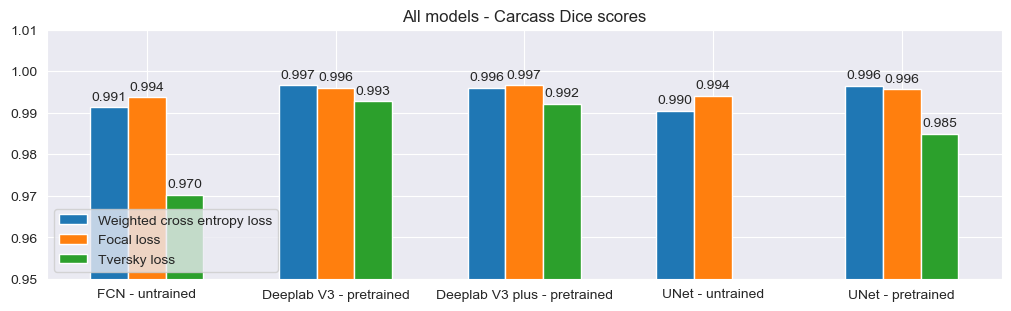

In [6]:

loss_name=["Weighted cross entropy loss","Focal loss","Tversky loss"]

runs=["FCN - untrained",
      "Deeplab V3 - pretrained",
      "Deeplab V3 plus - pretrained",
      "UNet - untrained",
      "UNet - pretrained",
      ]

x = np.arange(len(runs))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,3),layout='constrained')

for idx in range(len(carcassscores)):
    offset = width * multiplier
    rects = ax.bar(x + offset, [carcassscores[idx][idx2] for idx2 in range(len(runs))], width, label=loss_name[idx])
    ax.bar_label(rects, fmt="{:.3f}", padding=3)
    multiplier += 1

ax.set_xticks(x+width*len(runs)/5)
ax.set_xticklabels(runs)
ax.set_ylim(0.95,1.01)

plt.title("All models - Carcass Dice scores")
plt.legend(loc=3)
plt.savefig("All models - Carcass Dice scores.png")
plt.show()

#with open("All models - Carcass Dice scores.txt","w") as f:
#    f.write(f"Model\tWCE\tFL\tTL\n")
#    for i in range(len(runs)):
#        f.write(f"{runs[i]}\t"+"\t".join([f"{carcassscores[l][i]:.3}" for l in range(len(avescores))])+"\n")

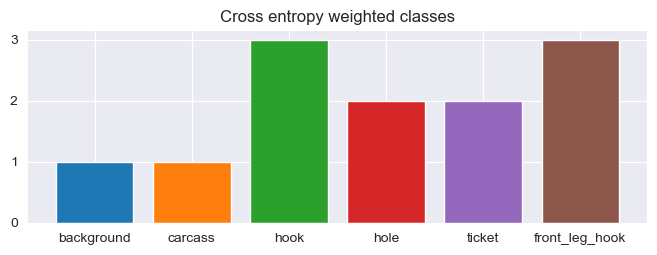

In [7]:
class_weights=[1.0,1.0,3.0,2.0,2.0,3.0]

fig = plt.figure(figsize=(8,2.5))

for c, w in zip(classes,class_weights):
    plt.bar(classes_labels[c],w,label=classes_labels[c])

plt.title("Cross entropy weighted classes")
plt.savefig("CE_class weights.png")
plt.show()